In [53]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from scipy.special import inv_boxcox
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from prophet import Prophet
from prophet.plot import plot
from xgboost import plot_importance, plot_tree
import xgboost as xgb
import warnings 
warnings.filterwarnings("ignore")

In [54]:
def Arima(file):
    df_air=pd.read_csv(file)
    df_air["Month"]=pd.to_datetime(df_air["Month"])
    display(df_air.head())
    df_air.plot(x="Month", y= "#Passengers")
    plt.ylabel("Passengers")
    plt.show()

    # Make the target variance stationary

    from scipy.stats import boxcox
    df_air["Passengers_boxcox"], lam=boxcox(df_air["#Passengers"])
    # print(lam)
    df_air.plot(x="Month", y= "Passengers_boxcox")
    plt.ylabel("Passengers")
    plt.show()



    # Difference the data
    df_air["Passengers_diff"]=df_air["Passengers_boxcox"].diff()
    df_air.dropna(inplace=True)

    plot_acf(df_air["Passengers_diff"])
    plt.show()
    plot_pacf(df_air["Passengers_diff"])
    plt.show()



    train=df_air.iloc[:int(len(df_air)*0.8)]
    test=df_air.iloc[int(len(df_air)*0.8):]

    model=ARIMA(train["Passengers_boxcox"],order=(12,1,12)).fit()
    boxcox_forecasts=model.forecast(len(test))
    forecasts=inv_boxcox(boxcox_forecasts,lam)
    
    
    plt.figure(figsize=(7,4))
    plt.plot(train['Month'],train['#Passengers'],color="blue",label="train")
    plt.plot(test['Month'],test['#Passengers'],color="green",label="train")
    plt.plot(test['Month'],forecasts,color="red",label="pred")
    plt.legend()
    plt.show()
    
    print(mean_squared_error(y_true=test["#Passengers"], y_pred=forecasts))
    print(mean_absolute_error(y_true=test["#Passengers"], y_pred=forecasts))
    

In [58]:

def prophet_model(file):
    df_pro=pd.read_csv(file)
    df_pro["Month"]=pd.to_datetime(df_pro["Month"])
    df_pro.dropna(inplace=True)
    display(df_pro.head())
    df_pro.plot(x="Month", y= "#Passengers")
    plt.ylabel("Passengers")

    df_pro=df_pro.rename({"Month":"ds","#Passengers":"y"},axis=1)
    train_pro=df_pro.iloc[:int(len(df_pro)*0.8)]
    test_pro=df_pro.iloc[int(len(df_pro)*0.8):]

    plt.figure(figsize=(7,4))
    plt.plot(train_pro["ds"],train_pro["y"],color="blue",label="train")
    plt.plot(test_pro["ds"],test_pro["y"],color="green",label="train")
    plt.legend()
    plt.show()

    model_pro=Prophet()
    model_pro.fit(train_pro)

    test_pro_=test_pro.drop(["y"],axis=1)
    pred_tst=model_pro.predict(test_pro_)
    plot(model_pro, pred_tst, figsize=(6, 3))
    plt.show()

    df_pro_test=df_pro.drop(["y"],axis=1)
    pred=model_pro.predict(df_pro_test)
    plot(model_pro, pred, figsize=(6, 3))
    plt.show()

    plt.figure(figsize=(7,4))
    plt.plot(train_pro["ds"],train_pro["y"],color="blue",label="train")
    plt.plot(test_pro["ds"],test_pro["y"],color="green",label="train")
    plt.plot(test_pro["ds"],pred_tst["yhat"],color="red",label="pred")
    plt.legend()
    plt.show()

    print(mean_squared_error(y_true=test_pro["y"], y_pred=pred_tst["yhat"]))
    print(mean_absolute_error(y_true=test_pro["y"], y_pred=pred_tst["yhat"]))

In [56]:

def xgb_model(file):
    df_xgb=pd.read_csv(file)
    df_xgb["Month"]=pd.to_datetime(df_xgb["Month"])
    df_xgb.dropna(inplace=True)
    display(df_xgb.head())
    df_xgb.plot(x="Month", y= "#Passengers")
    plt.ylabel("Passengers")

    train_xgb=df_xgb.iloc[:int(len(df_xgb)*0.8)]
    test_xgb=df_xgb.iloc[int(len(df_xgb)*0.8):]

    plt.figure(figsize=(7,4))
    plt.plot(train_xgb["Month"],train_xgb["#Passengers"],color="blue",label="train")
    plt.plot(test_xgb["Month"],test_xgb["#Passengers"],color="green",label="test")
    plt.legend()
    plt.show()


    #data preprocessing
    train_xgb['dayofweek'] = train_xgb['Month'].dt.dayofweek
    train_xgb['quarter'] =  train_xgb['Month'].dt.quarter
    train_xgb['month'] =  train_xgb['Month'].dt.month
    train_xgb['year'] =  train_xgb['Month'].dt.year
    train_xgb['dayofyear'] =  train_xgb['Month'].dt.dayofyear
    train_xgb['dayofmonth'] =  train_xgb['Month'].dt.day
    display(train_xgb.head())

    test_xgb['dayofweek'] = test_xgb['Month'].dt.dayofweek
    test_xgb['quarter'] =  test_xgb['Month'].dt.quarter
    test_xgb['month'] =  test_xgb['Month'].dt.month
    test_xgb['year'] =  test_xgb['Month'].dt.year
    test_xgb['dayofyear'] =  test_xgb['Month'].dt.dayofyear
    test_xgb['dayofmonth'] =  test_xgb['Month'].dt.day
    display(test_xgb.head())




    X_train=train_xgb.drop(["Month","#Passengers"],axis=1)
    y_train=train_xgb["#Passengers"]

    X_test=test_xgb.drop(["Month","#Passengers"],axis=1)
    y_test=test_xgb["#Passengers"]

    model_xgb=xgb.XGBRegressor(n_estimators=1000, learning_rate=0.01)
    model_xgb.fit(X_train,
                 y_train,
                 eval_set=[(X_train,y_train),(X_test,y_test)],
                 eval_metric='mae',
                 verbose=False)
    yhat = model_xgb.predict(X_test)

    plt.figure(figsize=(7,4))
    plt.plot(train_xgb["Month"],train_xgb["#Passengers"],color="blue",label="train")
    plt.plot(test_xgb["Month"],test_xgb["#Passengers"],color="green",label="train")
    plt.plot(test_xgb["Month"],yhat,color="red",label="pred")
    plt.legend()
    plt.show()

    print(mean_squared_error(y_true=test_xgb["#Passengers"], y_pred=yhat))
    print(mean_absolute_error(y_true=test_xgb["#Passengers"], y_pred=yhat))

################################----ARIMA Model-----################################


,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


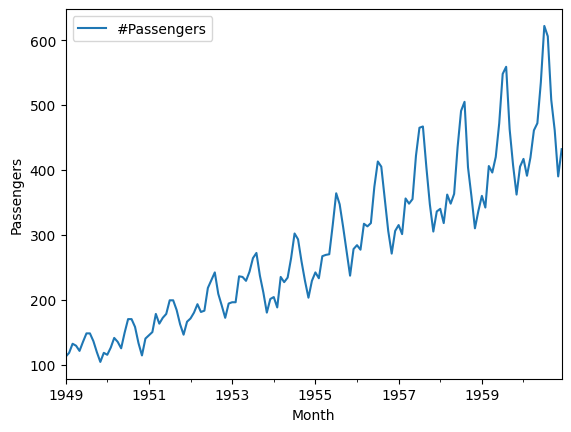

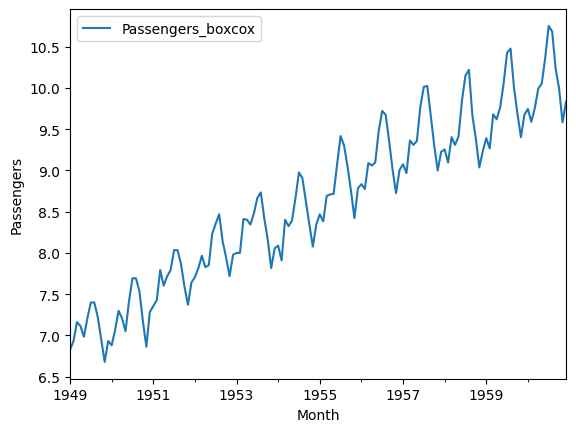

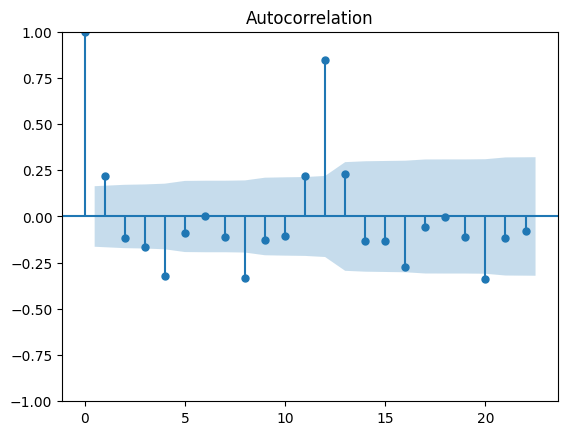

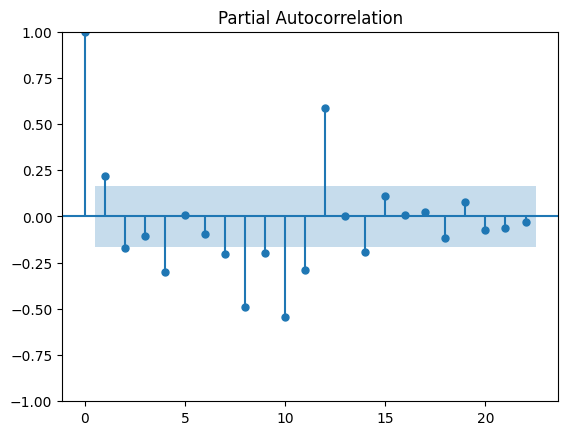

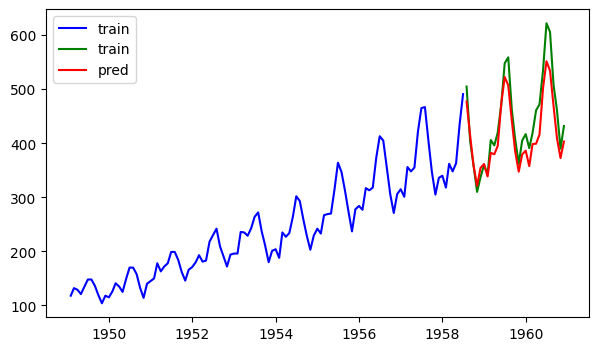

1161.4858830245266
27.985513689738134
#################################----Prophet Model-----################################


,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


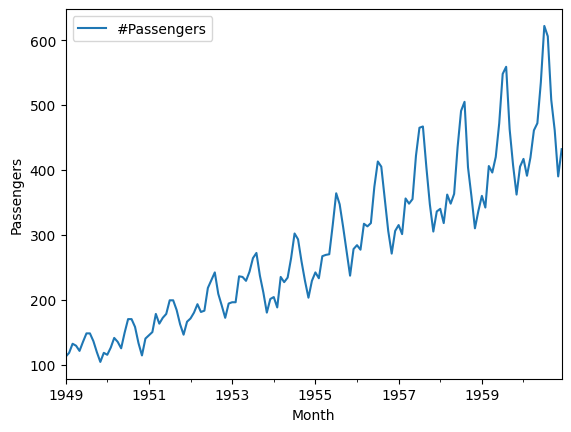

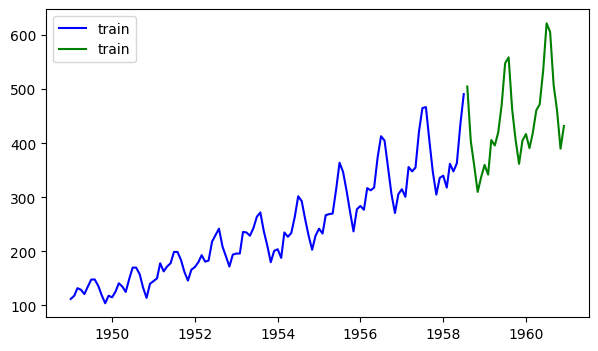

10:26:16 - cmdstanpy - INFO - Chain [1] start processing
10:26:16 - cmdstanpy - INFO - Chain [1] done processing


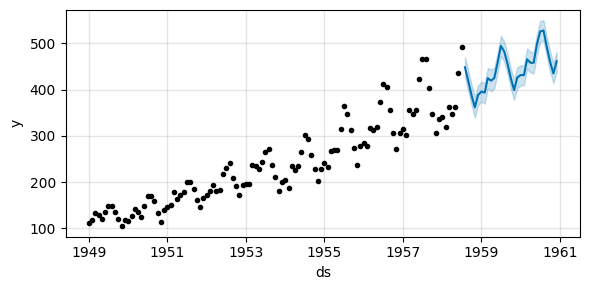

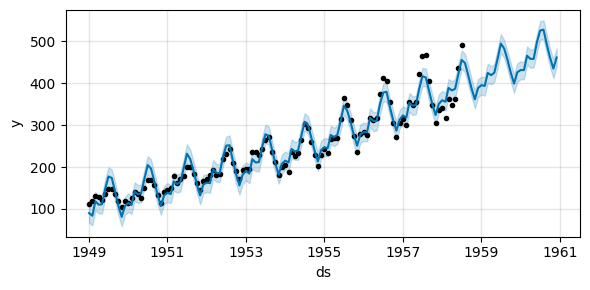

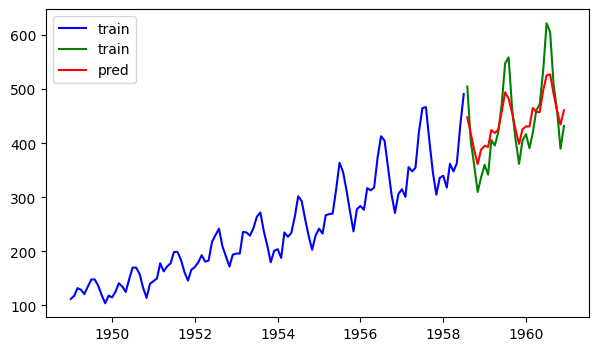

1708.6291306774463
33.90754576686349
###################################----XGBRegressor Model-----#################################


,Month,#Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


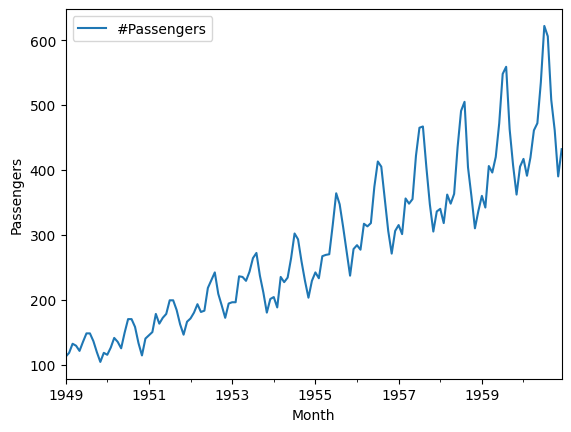

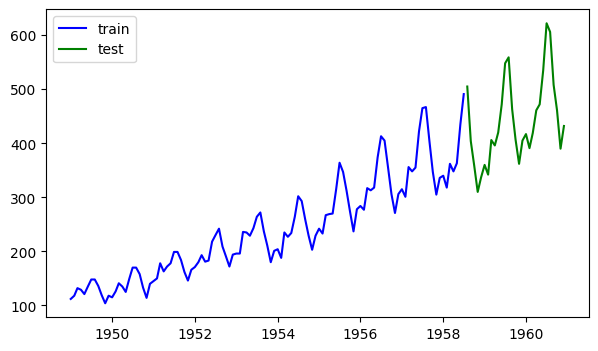

,Month,#Passengers,dayofweek,quarter,month,year,dayofyear,dayofmonth
0,1949-01-01,112,5,1,1,1949,1,1
1,1949-02-01,118,1,1,2,1949,32,1
2,1949-03-01,132,1,1,3,1949,60,1
3,1949-04-01,129,4,2,4,1949,91,1
4,1949-05-01,121,6,2,5,1949,121,1


,Month,#Passengers,dayofweek,quarter,month,year,dayofyear,dayofmonth
115,1958-08-01,505,4,3,8,1958,213,1
116,1958-09-01,404,0,3,9,1958,244,1
117,1958-10-01,359,2,4,10,1958,274,1
118,1958-11-01,310,5,4,11,1958,305,1
119,1958-12-01,337,0,4,12,1958,335,1


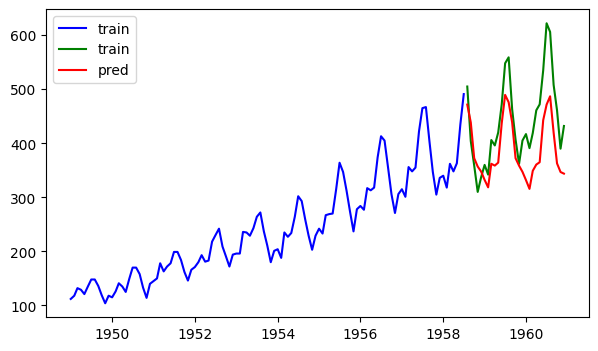

4862.454832511023
60.055832435344826


In [60]:
file="/kaggle/input/airpassengers/AirPassengers.csv"
print("################################----ARIMA Model-----################################")
Arima(file)
print("#################################----Prophet Model-----################################")
prophet_model(file)
print("###################################----XGBRegressor Model-----#################################")
xgb_model(file)